In [1]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline

import keras
from keras import objectives
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Multiply, Add
from keras.optimizers import Adam, Nadam
import salty
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from random import shuffle
import pandas as pd
import random

#Keras build
from keras import backend as K
from keras.objectives import binary_crossentropy #objs or losses
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Layer
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D

#chem
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys
import salty

#cation data
cations = pd.read_csv('../data/cations.csv')
cations = cations['smiles_string']
salts = pd.read_csv('../data/salts.csv')
salts = salts['smiles_string']
categories = pd.read_csv('../data/categories.csv')
categories = categories['category']
coldic = pd.read_csv('../data/coldic.csv')
coldic = coldic.to_dict(orient='records')[0]
salt_coldic = pd.read_csv('../data/salt_coldic.csv')
salt_coldic = salt_coldic.to_dict(orient='records')[0]
salt_categories = pd.read_csv('../data/salt_categories.csv')
salt_categories = salt_categories['category']
density_coldic = pd.read_csv('../data/density_coldic.csv')
density_coldic = density_coldic.to_dict(orient='records')[0]
density_categories = pd.read_csv('../data/density_categories.csv')
density_categories = density_categories['category']

#supporting functions
import sys
sys.path.insert(0, '../')
from scripts import *

#training array info
smile_max_length = 105
import json
f = open("../data/salt_char_to_index.json","r")
ani_char_to_index = json.loads(f.read())
ani_char_set = set(ani_char_to_index.keys())
ani_char_list = list(ani_char_to_index.keys())
ani_chars_in_dict = len(ani_char_list)
ani_index_to_char = dict((i, c) for i, c in enumerate(ani_char_list))

#training array info
import json
f = open("../data/gdb_char_to_index.json","r")
cat_char_to_index = json.loads(f.read())
cat_char_set = set(cat_char_to_index.keys())
cat_char_list = list(cat_char_to_index.keys())
cat_chars_in_dict = len(cat_char_list)
cat_index_to_char = dict((i, c) for i, c in enumerate(cat_char_list))

char_to_index = ani_char_to_index
char_set = ani_char_set
char_list = ani_char_list
chars_in_dict = ani_chars_in_dict
index_to_char = ani_index_to_char

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load models

In [29]:
gen1vae = MoleculeVAE()
gen1vae.create(char_set, qspr=True, mol_inputs=2, weights_file='../models/gen1_2mol_1mil_GDB17_mix_pure_5.h5')

In [30]:
gen1vae_density = MoleculeVAE()
gen1vae_density.create(char_set, qspr=True, mol_inputs=2, weights_file='../models/gen1vae_density_30.h5')

In [31]:
gen2vae = TwoMoleculeOneLatentVAE()
gen2vae.create(char_set, qspr=True, weights_file='../models/gen2_2mol_1mil_GDB17_mix_pure_5.h5')

In [32]:
gen2vae_density = TwoMoleculeOneLatentVAE()
gen2vae_density.create(char_set, qspr=True, weights_file='../models/gen2vae_density_30.h5')

In [33]:
gen3vae = TwoMoleculeVAE()
gen3vae.create(char_set, char_set, qspr=True, weights_file='../models/gen3_2mol_1mil_GDB17_mix_pure_5.h5')

In [34]:
gen3vae_density = TwoMoleculeVAE()
gen3vae_density.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_density_30.h5')

In [2]:
gen3vae_cpt = TwoMoleculeVAE()
gen3vae_cpt.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_cpt_10.h5')

# Sample Structures

cat seed:	CCCC[N+](CCCC)(CCCC)CCCC
ani seed:	[Cl-]
673.5722
sample:	CCCC[N+](CCCC)(CCCC)CCCC                                      [Br-]                                                         


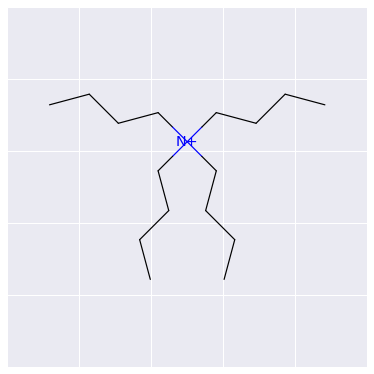

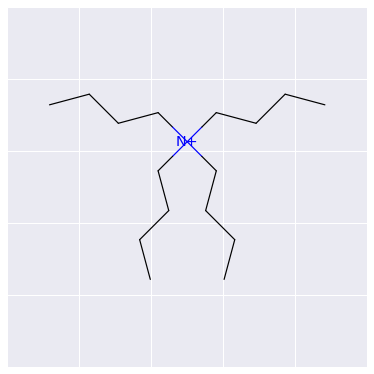

In [18]:
#two molecule vae
seed1 = salts[random.randint(0,len(salts))].split('.')[0]
seed2 = salts[random.randint(0,len(salts))].split('.')[1]
print("cat seed:\t{}".format(seed1))
print("ani seed:\t{}".format(seed2))
string = ""

for rindex, i in enumerate(gen3vae_cpt.autoencoder.predict([one_hot(seed1, char_to_index, smile_max_length=62),
                                             one_hot(seed2, char_to_index, smile_max_length=62)])):
    if len(i.shape) > 2:
        i = i[0] #for qspr chemvae there is an extra dim
    if rindex < 2:
        for j in i:
    #         print(j.shape)
            index = sample(j, temperature=0.2)
            string += cat_index_to_char[index]
        if rindex == 0:
            sampled = Chem.MolFromSmiles(string)
            cation = Chem.AddHs(sampled)
            Chem.EmbedMolecule(cation, Chem.ETKDG())
            Chem.UFFOptimizeMolecule(cation)
            cation = Chem.RemoveHs(cation)
            candidate = Chem.MolToSmiles(cation)
            fig1 = Draw.MolToMPL(Chem.MolFromSmiles(candidate), size=(200,200))
            fig2 = Draw.MolToMPL(Chem.MolFromSmiles(seed1), size=(200,200))
    else:
        print(np.exp(i[0][0]))
print("sample:\t{}".format(string))

cat seed:	C1=C[N+](CCCCCC)=CN1CCCCCC
ani seed:	CC(=O)[O-]
830.8952
sample:	C1=C[N+](CCCCCC)=CN1CCCCCC                                    CC(=O)[O-]                                                    


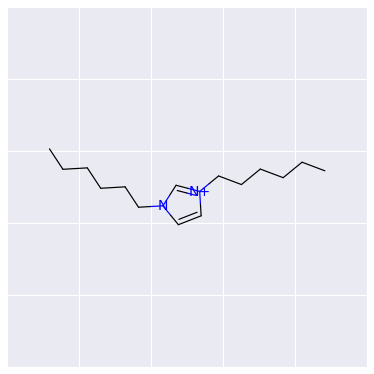

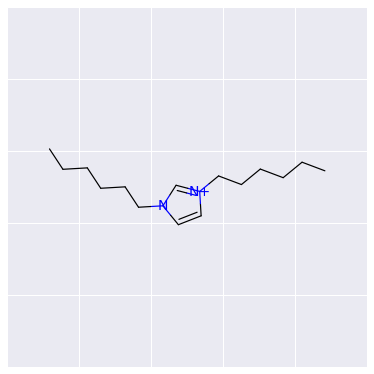

In [8]:
#two molecule vae
seed1 = salts[random.randint(0,len(salts))].split('.')[0]
seed2 = salts[random.randint(0,len(salts))].split('.')[1]
print("cat seed:\t{}".format(seed1))
print("ani seed:\t{}".format(seed2))
string = ""

for rindex, i in enumerate(gen3vae_density.autoencoder.predict([one_hot(seed1, char_to_index, smile_max_length=62),
                                             one_hot(seed2, char_to_index, smile_max_length=62)])):
    if len(i.shape) > 2:
        i = i[0] #for qspr chemvae there is an extra dim
    if rindex < 2:
        for j in i:
    #         print(j.shape)
            index = sample(j, temperature=0.02)
            string += cat_index_to_char[index]
        if rindex == 0:
            sampled = Chem.MolFromSmiles(string)
            cation = Chem.AddHs(sampled)
            Chem.EmbedMolecule(cation, Chem.ETKDG())
            Chem.UFFOptimizeMolecule(cation)
            cation = Chem.RemoveHs(cation)
            candidate = Chem.MolToSmiles(cation)
            fig1 = Draw.MolToMPL(Chem.MolFromSmiles(candidate), size=(200,200))
            fig2 = Draw.MolToMPL(Chem.MolFromSmiles(seed1), size=(200,200))
    else:
        print(np.exp(i[0][0]))
print("sample:\t{}".format(string))

qspr output:	1026.4844970703125
cat seed:	O(C)CCn1cc[n+](c1)C
cat sample:	C[n+]1ccn(CCCC#N)c1
ani seed:	C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F
attempts:	23


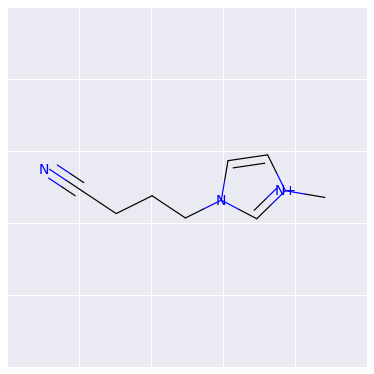

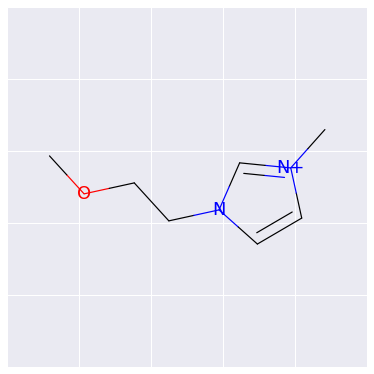

In [28]:
#two molecule vae
attempts = 0
while True:
    attempts += 1
    try:
        seed1 = salts[random.randint(0,len(salts)-1)].split('.')[0]
        seed2 = salts[random.randint(0,len(salts)-1)].split('.')[1]
        for rindex, i in enumerate(gen3vae_density.autoencoder.predict([one_hot(seed1, char_to_index, smile_max_length=62),
                                                     one_hot(seed2, char_to_index, smile_max_length=62)])):
            string = ""
            if len(i.shape) > 2:
                i = i[0] #for qspr chemvae there is an extra dim
            if rindex == 0:
                for j in i:
                    index = sample(j, temperature=max(0.1,random.random()*1))
                    string += cat_index_to_char[index]    
                sampled = Chem.MolFromSmiles(string)
                cation = Chem.AddHs(sampled)
                Chem.EmbedMolecule(cation, Chem.ETKDG())
                Chem.UFFOptimizeMolecule(cation)
                cation = Chem.RemoveHs(cation)
                candidate = Chem.MolToSmiles(cation)
        molseed = Chem.MolFromSmiles(seed1)
        Chem.EmbedMolecule(molseed, Chem.ETKDG())
        Chem.UFFOptimizeMolecule(molseed)
        molseed = Chem.RemoveHs(molseed)
        molseedsmi = Chem.MolToSmiles(molseed)
        if molseedsmi == candidate:
            continue
        fig1 = Draw.MolToMPL(Chem.MolFromSmiles(candidate), size=(200,200))
        fig2 = Draw.MolToMPL(Chem.MolFromSmiles(seed1), size=(200,200))
        print("qspr output:\t{}".format(np.exp(i[0][0])))
        print("cat seed:\t{}".format(seed1))
        print("cat sample:\t{}".format(candidate))
        print("ani seed:\t{}".format(seed2))
        print("attempts:\t{}".format(attempts))
        break
    except:
        pass

qspr output:	1092.1160888671875
cat seed:	C[N+](C)(C)CCOC
cat sample:	CCn1cc[n+](C)c1
ani seed:	CCCCO[P@@H](=O)[O-]
attempts:	48


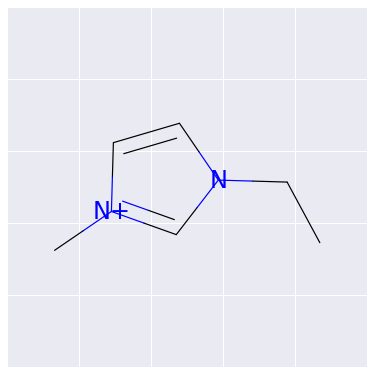

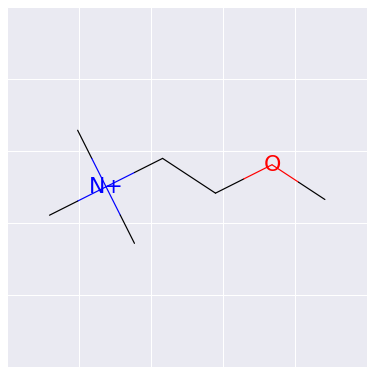

In [35]:
#two molecule vae
attempts = 0
while True:
    attempts += 1
    try:
        seed1 = salts[random.randint(0,len(salts)-1)].split('.')[0]
        seed2 = salts[random.randint(0,len(salts)-1)].split('.')[1]
        for rindex, i in enumerate(gen1vae_density.autoencoder.predict([one_hot(seed1, char_to_index, smile_max_length=62),
                                                     one_hot(seed2, char_to_index, smile_max_length=62)])):
            string = ""
            if len(i.shape) > 2:
                i = i[0] #for qspr chemvae there is an extra dim
            if rindex == 0:
                for j in i:
                    index = sample(j, temperature=max(0.1,random.random()*1))
                    string += cat_index_to_char[index]    
                sampled = Chem.MolFromSmiles(string)
                cation = Chem.AddHs(sampled)
                Chem.EmbedMolecule(cation, Chem.ETKDG())
                Chem.UFFOptimizeMolecule(cation)
                cation = Chem.RemoveHs(cation)
                candidate = Chem.MolToSmiles(cation)
        molseed = Chem.MolFromSmiles(seed1)
        Chem.EmbedMolecule(molseed, Chem.ETKDG())
        Chem.UFFOptimizeMolecule(molseed)
        molseed = Chem.RemoveHs(molseed)
        molseedsmi = Chem.MolToSmiles(molseed)
        if molseedsmi == candidate:
            continue
        fig1 = Draw.MolToMPL(Chem.MolFromSmiles(candidate), size=(200,200))
        fig2 = Draw.MolToMPL(Chem.MolFromSmiles(seed1), size=(200,200))
        print("qspr output:\t{}".format(np.exp(i[0][0])))
        print("cat seed:\t{}".format(seed1))
        print("cat sample:\t{}".format(candidate))
        print("ani seed:\t{}".format(seed2))
        print("attempts:\t{}".format(attempts))
        break
    except:
        pass

qspr output:	1472.9268798828125
cat seed:	[P+](CC)(CC)(CC)CCCCCCCC
cat sample:	CCCCCCCCCCN1C=CCCCC1CCCCC
ani seed:	C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F
attempts:	1008


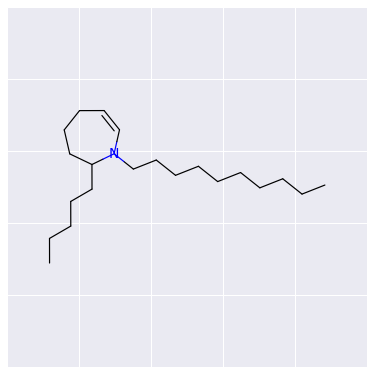

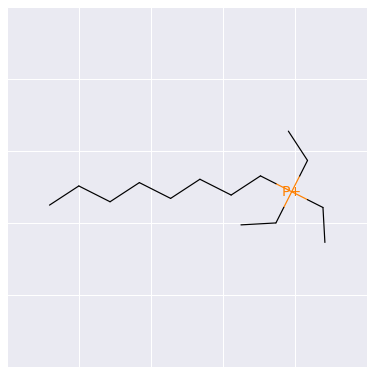

In [36]:
#two molecule vae
attempts = 0
while True:
    attempts += 1
    try:
        seed1 = salts[random.randint(0,len(salts)-1)].split('.')[0]
        seed2 = salts[random.randint(0,len(salts)-1)].split('.')[1]
        for rindex, i in enumerate(gen2vae_density.autoencoder.predict([one_hot(seed1, char_to_index, smile_max_length=62),
                                                     one_hot(seed2, char_to_index, smile_max_length=62)])):
            string = ""
            if len(i.shape) > 2:
                i = i[0] #for qspr chemvae there is an extra dim
            if rindex == 0:
                for j in i:
                    index = sample(j, temperature=max(0.1,random.random()*1))
                    string += cat_index_to_char[index]    
                sampled = Chem.MolFromSmiles(string)
                cation = Chem.AddHs(sampled)
                Chem.EmbedMolecule(cation, Chem.ETKDG())
                Chem.UFFOptimizeMolecule(cation)
                cation = Chem.RemoveHs(cation)
                candidate = Chem.MolToSmiles(cation)
        molseed = Chem.MolFromSmiles(seed1)
        Chem.EmbedMolecule(molseed, Chem.ETKDG())
        Chem.UFFOptimizeMolecule(molseed)
        molseed = Chem.RemoveHs(molseed)
        molseedsmi = Chem.MolToSmiles(molseed)
        if molseedsmi == candidate:
            continue
        fig1 = Draw.MolToMPL(Chem.MolFromSmiles(candidate), size=(200,200))
        fig2 = Draw.MolToMPL(Chem.MolFromSmiles(seed1), size=(200,200))
        print("qspr output:\t{}".format(np.exp(i[0][0])))
        print("cat seed:\t{}".format(seed1))
        print("cat sample:\t{}".format(candidate))
        print("ani seed:\t{}".format(seed2))
        print("attempts:\t{}".format(attempts))
        break
    except:
        pass

# Search by Property

The general setup-
1. generate N structures of target Cp and p values from the VAE and GA (and maybe a VAE w/o QSPR --- use a separate QSPR --- this would be to show that the organization of the latent space is actually helping…)
2. calculate ground-truth values using QM/MD
3. compare the % of the found structures that were close to the target for each method.

So the table is:

- **properties**: p, Cp
- **models**: VAE, VAE+QSPR, EA
- **number of**: total function calls, returned structures rdkit-sanitizable, returned gaussian structures, returned MD systems, % error of prediction

The basic setup is here. we will want to, however, throw out structures where the Cp/p was far from our top 10 structure seeds (high Cp, low p)

We seed all methods with the top 10 structures from our dataset. 

In [2]:
# gen3vae_density = TwoMoleculeVAE()
# gen3vae_density.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_density_10.h5')
gen3vae_cpt = TwoMoleculeVAE()
gen3vae_cpt.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_cpt_10.h5')
# gen3vae_viscosity = TwoMoleculeVAE()
# gen3vae_viscosity.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_viscosity_10.h5')
# gen3vae_thermal = TwoMoleculeVAE()
# gen3vae_thermal.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_thermal_conductivity_10.h5')
# gen3vae_melting = TwoMoleculeVAE()
# gen3vae_melting.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_melting_point_10.h5')

In [3]:
props = ['cpt']
T = [297, 316]
P = [99, 102]
devmodel = salty.aggregate_data(props, T=T, P=P, merge='Union')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation'] + "." + devmodel.Data['smiles-anion']
salts = devmodel.Data['smiles_string']
salts = salts.reset_index(drop=True)

property_index = 6
if props == 'melting_point':
    property_index = 8
print(devmodel.Data.columns[-property_index])
print("total salts in training data:\t{}".format(salts.shape[0]))

Heat capacity at constant pressure, J/K/mol
total salts in training data:	1739


In [4]:
df = devmodel.Data

In [5]:
salts = df.sort_values('Heat capacity at constant pressure, J/K/mol', ascending=False)['smiles_string'][:73].unique()

In [6]:
np.exp(df.sort_values('Heat capacity at constant pressure, J/K/mol', ascending=False)['Heat capacity at constant pressure, J/K/mol'][:73].unique())

array([9000., 7630., 6300., 4860., 3480., 2290., 1697., 1667., 1656.,
       1645., 1635., 1438., 1379., 1372., 1368., 1366., 1357., 1342.,
       1320., 1278., 1275., 1274., 1273., 1272., 1271., 1270., 1269.,
       1268., 1267., 1266., 1262., 1261., 1257., 1254., 1253., 1251.,
       1248., 1242., 1235., 1229., 1222., 1219., 1207., 1193., 1187.,
       1177., 1161., 1146., 1130., 1129., 1113., 1103., 1098., 1097.,
       1084., 1082., 1081., 1070., 1068., 1060., 1054., 1053., 1051.,
       1032., 1020.])

In [7]:
print(salts)
print(len(salts))

['CCCCCC[n+]1cccc2c1cccc2.C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F'
 'CCCn1cc[n+](c1)C.[Br-]'
 'C[n+]1cc[nH]c1.CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-]'
 'CCCCCCCCCCCCCCn1cc[n+](c1)C.C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F'
 'C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC.FC(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F'
 'C[n+]1cc[nH]c1.Cl[Fe-](Cl)(Cl)Cl'
 'CCCC[N+](CCCC)(CCCC)CCCC.CCCCC(CC)COC(=O)CC(C(=O)OCC(CC)CCCC)S(=O)(=O)[O-]'
 'CCCCCCCCCCCCCCCCn1cc[n+](c1)C.C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F'
 'C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC.C(#N)[N-]C#N'
 'CCCC[P+](CCCC)(CCCC)CCCC.C(CCN)C[C@@H](C(=O)[O-])N']
10


In [8]:
cations = [i.split('.')[0] for i in salts]
anions = [i.split('.')[1] for i in salts]

print("first training sample:\t{}\t{}".format(cations[0], anions[0]))
print("last training sample:\t{}\t{}".format(cations[-1], anions[-1]))

padded_cations =  [pad_smiles(i, smile_max_length) for i in cations if pad_smiles(i, smile_max_length)]
padded_anions =  [pad_smiles(i, smile_max_length) for i in anions if pad_smiles(i, smile_max_length)]
X_train_cat = np.zeros((len(cations), smile_max_length, chars_in_dict), dtype=np.float32)
X_train_ani = np.zeros((len(anions), smile_max_length, chars_in_dict), dtype=np.float32)
Y_train = np.array(devmodel.Data[devmodel.Data.columns[-property_index]])

for i, smile in enumerate(padded_cations):
    for j, char in enumerate(smile):
        X_train_cat[i, j, char_to_index[char]] = 1

for i, smile in enumerate(padded_anions):
    for j, char in enumerate(smile):
        X_train_ani[i, j, char_to_index[char]] = 1

first training sample:	CCCCCC[n+]1cccc2c1cccc2	C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F
last training sample:	CCCC[P+](CCCC)(CCCC)CCCC	C(CCN)C[C@@H](C(=O)[O-])N


In [9]:
found_di = {'cat seed': [],
         'ani seed': [],
         'temperature': [],
          'candidate': [],
         'qspr': []}
found_di

{'ani seed': [],
 'candidate': [],
 'cat seed': [],
 'qspr': [],
 'temperature': []}

In [10]:
#two molecule vae
attempts = 0
found = 0
find = 100
while True:
    attempts += 1
    try:
        seed1 = salts[random.randint(0,len(salts)-1)].split('.')[0]
        seed2 = salts[random.randint(0,len(salts)-1)].split('.')[1]
        for rindex, i in enumerate(gen3vae_cpt.autoencoder.predict([one_hot(seed1, char_to_index, smile_max_length=62),
                                                     one_hot(seed2, char_to_index, smile_max_length=62)])):
            string = ""
            if len(i.shape) > 2:
                i = i[0] #for qspr chemvae there is an extra dim
            if rindex == 0:
                temp=max(0.1,random.random()*2)
                for j in i:
                    index = sample(j, temperature=temp)
                    string += cat_index_to_char[index]    
                sampled = Chem.MolFromSmiles(string)
                cation = Chem.AddHs(sampled)
                Chem.EmbedMolecule(cation, Chem.ETKDG())
                Chem.UFFOptimizeMolecule(cation)
                cation = Chem.RemoveHs(cation)
                candidate = Chem.MolToSmiles(cation)
        molseed = Chem.MolFromSmiles(seed1)
        Chem.EmbedMolecule(molseed, Chem.ETKDG())
        Chem.UFFOptimizeMolecule(molseed)
        molseed = Chem.RemoveHs(molseed)
        molseedsmi = Chem.MolToSmiles(molseed)
        if molseedsmi == candidate:
            continue
        if np.exp(i[0][0]) > 1020: #these are the hard-coded top 10 values for Cp
            if np.exp(i[0][0]) < 9000:
                if molseedsmi not in found_di['candidate']:
                    print("qspr output:\t{}".format(np.exp(i[0][0])))
                    found_di['qspr'].append(np.exp(i[0][0]))
                    print("cat seed:\t{}".format(seed1))
                    found_di['cat seed'].append(seed1)
                    print("ani seed:\t{}".format(seed2))
                    found_di['ani seed'].append(seed2)
                    print("cat sample:\t{}".format(candidate))
                    found_di['candidate'].append(candidate)
                    print("attempts:\t{}".format(attempts))
                    found_di['temperature'].append(temp)
                    found += 1
        if find <= found:
            break
        if attempts % 100 == 0:
            print(attempts)
    except:
        pass

qspr output:	2736.910888671875
cat seed:	CCCC[P+](CCCC)(CCCC)CCCC
ani seed:	CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-]
cat sample:	CCCC[P+](CCCC)(CCCC)OCCC
attempts:	73
qspr output:	1460.689697265625
cat seed:	CCCCCCCCCCCCCCn1cc[n+](c1)C
ani seed:	CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-]
cat sample:	C=CCCCCCCCCCCCn1cc[n+](C)c1
attempts:	324
qspr output:	1295.48486328125
cat seed:	C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC
ani seed:	C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F
cat sample:	CCCCCCCCCCCC(CCCCCC)C[P+](C)(CCCC)CCCCCC
attempts:	522
qspr output:	1593.853515625
cat seed:	CCCCCCCCCCCCCCCCn1cc[n+](c1)C
ani seed:	CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-]
cat sample:	CCCCCCCCCCCCCCCCN1C=C[N+]=C1
attempts:	654
qspr output:	1224.1978759765625
cat seed:	C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC
ani seed:	C(CCN)C[C@@H](C(=O)[O-])N
cat sample:	CCCCCC[P+](CCCCCC)(CCCCCC)CCCCCCCCCCCCOC
attempts:	755
qspr output:	1655.5650634765625
cat seed:	CCCCCCCCCCCCCCCCn1cc[n+](c1)C
ani seed:	CC(CC(C)(C)C)CP(=

In [12]:
df_gen3vae_cpt_qspr_8289_function_calls = pd.DataFrame(found_di).sort_values('qspr', ascending=False)

In [13]:
df_gen3vae_cpt_qspr_8289_function_calls.to_csv('../data/df_gen3vae_cpt_qspr_8289_function_calls', index=False)

In [15]:
pd.read_csv('../data/df_gen3vae_cpt_qspr_8289_function_calls')

,ani seed,candidate,cat seed,qspr,temperature
0,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,4920.865723,1.741173
1,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCCCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,4872.863281,1.334617
2,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCCCCCCCCCC(CCCCCC)C[P+](C)(CCCC)CCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,4796.685059,1.719600
3,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,4602.587402,1.271056
4,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCCCCCCCCCPCC[P+](CCCCCC)(CCCCCC)CCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,4545.942871,1.743234
5,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCCCCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,4387.599609,1.829451
6,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCCCCNCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,4371.460938,1.704072
7,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCCCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,4269.915039,1.425511
8,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCCCCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,4268.604004,0.783285
9,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCC[N+](CCCC)(CCCC)OCC,CCCC[N+](CCCC)(CCCC)CCCC,2911.522461,1.381548


# w/o QSPR

In [2]:
# gen3vae_density = TwoMoleculeVAE()
# gen3vae_density.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_density_10.h5')
gen3vae_cpt = TwoMoleculeVAE()
gen3vae_cpt.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_cpt_10.h5')
# gen3vae_viscosity = TwoMoleculeVAE()
# gen3vae_viscosity.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_viscosity_10.h5')
# gen3vae_thermal = TwoMoleculeVAE()
# gen3vae_thermal.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_thermal_conductivity_10.h5')
# gen3vae_melting = TwoMoleculeVAE()
# gen3vae_melting.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_melting_point_10.h5')

In [3]:
props = ['cpt']
T = [297, 316]
P = [99, 102]
devmodel = salty.aggregate_data(props, T=T, P=P, merge='Union')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation'] + "." + devmodel.Data['smiles-anion']
salts = devmodel.Data['smiles_string']
salts = salts.reset_index(drop=True)

property_index = 6
if props == 'melting_point':
    property_index = 8
print(devmodel.Data.columns[-property_index])
print("total salts in training data:\t{}".format(salts.shape[0]))

Heat capacity at constant pressure, J/K/mol
total salts in training data:	1739


In [4]:
df = devmodel.Data

In [5]:
salts = df.sort_values('Heat capacity at constant pressure, J/K/mol', ascending=False)['smiles_string'][:73].unique()

In [6]:
np.exp(df.sort_values('Heat capacity at constant pressure, J/K/mol', ascending=False)['Heat capacity at constant pressure, J/K/mol'][:73].unique())

array([9000., 7630., 6300., 4860., 3480., 2290., 1697., 1667., 1656.,
       1645., 1635., 1438., 1379., 1372., 1368., 1366., 1357., 1342.,
       1320., 1278., 1275., 1274., 1273., 1272., 1271., 1270., 1269.,
       1268., 1267., 1266., 1262., 1261., 1257., 1254., 1253., 1251.,
       1248., 1242., 1235., 1229., 1222., 1219., 1207., 1193., 1187.,
       1177., 1161., 1146., 1130., 1129., 1113., 1103., 1098., 1097.,
       1084., 1082., 1081., 1070., 1068., 1060., 1054., 1053., 1051.,
       1032., 1020.])

In [7]:
print(salts)
print(len(salts))

['CCCCCC[n+]1cccc2c1cccc2.C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F'
 'CCCn1cc[n+](c1)C.[Br-]'
 'C[n+]1cc[nH]c1.CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-]'
 'CCCCCCCCCCCCCCn1cc[n+](c1)C.C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F'
 'C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC.FC(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F'
 'C[n+]1cc[nH]c1.Cl[Fe-](Cl)(Cl)Cl'
 'CCCC[N+](CCCC)(CCCC)CCCC.CCCCC(CC)COC(=O)CC(C(=O)OCC(CC)CCCC)S(=O)(=O)[O-]'
 'CCCCCCCCCCCCCCCCn1cc[n+](c1)C.C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F'
 'C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC.C(#N)[N-]C#N'
 'CCCC[P+](CCCC)(CCCC)CCCC.C(CCN)C[C@@H](C(=O)[O-])N']
10


In [8]:
cations = [i.split('.')[0] for i in salts]
anions = [i.split('.')[1] for i in salts]

print("first training sample:\t{}\t{}".format(cations[0], anions[0]))
print("last training sample:\t{}\t{}".format(cations[-1], anions[-1]))

padded_cations =  [pad_smiles(i, smile_max_length) for i in cations if pad_smiles(i, smile_max_length)]
padded_anions =  [pad_smiles(i, smile_max_length) for i in anions if pad_smiles(i, smile_max_length)]
X_train_cat = np.zeros((len(cations), smile_max_length, chars_in_dict), dtype=np.float32)
X_train_ani = np.zeros((len(anions), smile_max_length, chars_in_dict), dtype=np.float32)
Y_train = np.array(devmodel.Data[devmodel.Data.columns[-property_index]])

for i, smile in enumerate(padded_cations):
    for j, char in enumerate(smile):
        X_train_cat[i, j, char_to_index[char]] = 1

for i, smile in enumerate(padded_anions):
    for j, char in enumerate(smile):
        X_train_ani[i, j, char_to_index[char]] = 1

first training sample:	CCCCCC[n+]1cccc2c1cccc2	C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F
last training sample:	CCCC[P+](CCCC)(CCCC)CCCC	C(CCN)C[C@@H](C(=O)[O-])N


In [9]:
found_di = {'cat seed': [],
         'ani seed': [],
         'temperature': [],
          'candidate': [],
         'qspr': []}
found_di

{'ani seed': [],
 'candidate': [],
 'cat seed': [],
 'qspr': [],
 'temperature': []}

In [10]:
#two molecule vae
attempts = 0
found = 0
find = 100
while True:
    attempts += 1
    try:
        seed1 = salts[random.randint(0,len(salts)-1)].split('.')[0]
        seed2 = salts[random.randint(0,len(salts)-1)].split('.')[1]
        for rindex, i in enumerate(gen3vae_cpt.autoencoder.predict([one_hot(seed1, char_to_index, smile_max_length=62),
                                                     one_hot(seed2, char_to_index, smile_max_length=62)])):
            string = ""
            if len(i.shape) > 2:
                i = i[0] #for qspr chemvae there is an extra dim
            if rindex == 0:
                temp=max(0.1,random.random()*2)
                for j in i:
                    index = sample(j, temperature=temp)
                    string += cat_index_to_char[index]    
                sampled = Chem.MolFromSmiles(string)
                cation = Chem.AddHs(sampled)
                Chem.EmbedMolecule(cation, Chem.ETKDG())
                Chem.UFFOptimizeMolecule(cation)
                cation = Chem.RemoveHs(cation)
                candidate = Chem.MolToSmiles(cation)
        molseed = Chem.MolFromSmiles(seed1)
        Chem.EmbedMolecule(molseed, Chem.ETKDG())
        Chem.UFFOptimizeMolecule(molseed)
        molseed = Chem.RemoveHs(molseed)
        molseedsmi = Chem.MolToSmiles(molseed)
        if molseedsmi == candidate:
            continue
        if np.exp(i[0][0]) > 1020: #these are the hard-coded top 10 values for Cp
            if np.exp(i[0][0]) < 9000:
                if molseedsmi not in found_di['candidate']:
                    print("qspr output:\t{}".format(np.exp(i[0][0])))
                    found_di['qspr'].append(np.exp(i[0][0]))
                    print("cat seed:\t{}".format(seed1))
                    found_di['cat seed'].append(seed1)
                    print("ani seed:\t{}".format(seed2))
                    found_di['ani seed'].append(seed2)
                    print("cat sample:\t{}".format(candidate))
                    found_di['candidate'].append(candidate)
                    print("attempts:\t{}".format(attempts))
                    found_di['temperature'].append(temp)
                    found += 1
        if find <= found:
            break
        if attempts % 100 == 0:
            print(attempts)
    except:
        pass

qspr output:	2736.910888671875
cat seed:	CCCC[P+](CCCC)(CCCC)CCCC
ani seed:	CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-]
cat sample:	CCCC[P+](CCCC)(CCCC)OCCC
attempts:	73
qspr output:	1460.689697265625
cat seed:	CCCCCCCCCCCCCCn1cc[n+](c1)C
ani seed:	CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-]
cat sample:	C=CCCCCCCCCCCCn1cc[n+](C)c1
attempts:	324
qspr output:	1295.48486328125
cat seed:	C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC
ani seed:	C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F
cat sample:	CCCCCCCCCCCC(CCCCCC)C[P+](C)(CCCC)CCCCCC
attempts:	522
qspr output:	1593.853515625
cat seed:	CCCCCCCCCCCCCCCCn1cc[n+](c1)C
ani seed:	CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-]
cat sample:	CCCCCCCCCCCCCCCCN1C=C[N+]=C1
attempts:	654
qspr output:	1224.1978759765625
cat seed:	C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC
ani seed:	C(CCN)C[C@@H](C(=O)[O-])N
cat sample:	CCCCCC[P+](CCCCCC)(CCCCCC)CCCCCCCCCCCCOC
attempts:	755
qspr output:	1655.5650634765625
cat seed:	CCCCCCCCCCCCCCCCn1cc[n+](c1)C
ani seed:	CC(CC(C)(C)C)CP(=

In [12]:
df_gen3vae_cpt_qspr_8289_function_calls = pd.DataFrame(found_di).sort_values('qspr', ascending=False)

In [13]:
df_gen3vae_cpt_qspr_8289_function_calls.to_csv('../data/df_gen3vae_cpt_qspr_8289_function_calls', index=False)

In [15]:
pd.read_csv('../data/df_gen3vae_cpt_qspr_8289_function_calls')

,ani seed,candidate,cat seed,qspr,temperature
0,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,4920.865723,1.741173
1,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCCCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,4872.863281,1.334617
2,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCCCCCCCCCC(CCCCCC)C[P+](C)(CCCC)CCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,4796.685059,1.719600
3,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,4602.587402,1.271056
4,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCCCCCCCCCPCC[P+](CCCCCC)(CCCCCC)CCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,4545.942871,1.743234
5,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCCCCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,4387.599609,1.829451
6,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCCCCNCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,4371.460938,1.704072
7,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCCCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,4269.915039,1.425511
8,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCCCCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,4268.604004,0.783285
9,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],CCCC[N+](CCCC)(CCCC)OCC,CCCC[N+](CCCC)(CCCC)CCCC,2911.522461,1.381548


In [32]:
pd.DataFrame(found_di).sort_values('qspr', ascending=False)

,cat seed,ani seed,temperature,candidate,qspr
94,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],1.709168,C#CCCCCCCC[P+](CCCCC)(CCCCCC)CCCCCCCCCCCCC,4776.777344
102,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],1.849553,CCCCCCCCCCCCCC[P+](CCCCCC)CCCCCCCPCCCCCC,4741.416992
66,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],1.608287,CCCCCCCCCCCCCC[P+](CCCCCC)CCCCCCC(CC)CCC,4663.765625
74,CCCC[N+](CCCC)(CCCC)CCCC,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],1.550798,CCCC[N+](CCCC)CCCC,2867.511230
95,CCCC[N+](CCCC)(CCCC)CCCC,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],1.469449,CCCC[N+](CCCC)(CCCC)NCCC,2863.524170
30,CCCC[N+](CCCC)(CCCC)CCCC,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],1.316124,CCCC[N+](CCC)(CCCC)CCCC,2824.837402
45,CCCC[N+](CCCC)(CCCC)CCCC,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],1.292665,CCCC[N+](CCC)(CCCC)CCCC,2788.003906
16,CCCC[N+](CCCC)(CCCC)CCCC,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],1.915225,CCCC[N+](CCCC)(CCCC)CCOC,2786.286865
13,CCCC[P+](CCCC)(CCCC)CCCC,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],1.489338,CCCC[P+](CCC)(CCCC)CCCC,2681.104980
98,CCCC[N+](CCCC)(CCCC)CCCC,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-],1.411495,CCCC[N+](CCCC)(CCCC)CCNC,2669.937988


In [31]:
Out[32]

KeyError: 32